# Note : 
- [Log Sum Trick](https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)

In [1]:
import numpy as np 
from matplotlib import pyplot as plt 
from itertools import count
from tqdm import tqdm
import time
from IPython.display import clear_output

In [2]:
def kotak_kotak(n):
    def labeling(x, y):
        if x <= 0.5:
            if y >= 0.5: 
                return 1
            else : 
                return 0
        else : 
            if y < 0.5:
                return 1
            else : 
                return 0
                
    dataset = []
    for i in range(n):
        x, y = np.random.rand(), np.random.rand()
        data = np.array((x, y, labeling(x, y)))
        dataset.append(data)
    
    return np.array(dataset)

In [3]:
def spiral(n, lapis, kedekatan=1.5):
    theta = np.sqrt(np.random.rand(n)) * lapis * np.pi
    
    r_a = kedekatan*theta + np.pi
    data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
    x_a = data_a + np.random.randn(n,2)
    
    r_b = -kedekatan*theta - np.pi
    data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
    x_b = data_b + np.random.randn(n,2)
    
    res_a = np.append(x_a, np.zeros((n,1)), axis=1)
    res_b = np.append(x_b, np.ones((n,1)), axis=1)
    
    res = np.append(res_a, res_b, axis=0)
    np.random.shuffle(res)    
    return res  

In [4]:
trainset = spiral(300, 3, 2)
testset = spiral(100, 3, 2)
# trainset = kotak_kotak(300)
# testset  = kotak_kotak(100)

In [5]:
trainset[:5]

array([[ 16.95508615,   5.10735942,   0.        ],
       [  6.51038301, -18.03142276,   1.        ],
       [  6.41504636,  17.17287866,   0.        ],
       [-17.35347896,   0.05399372,   1.        ],
       [-21.47708977,   8.1452231 ,   0.        ]])

# Plot

In [6]:
# data label 0
label1 = np.array([ data for data in trainset if data[2] == 1])
label0 = np.array([ data for data in trainset if data[2] == 0])

In [7]:
label1.shape

(300, 3)

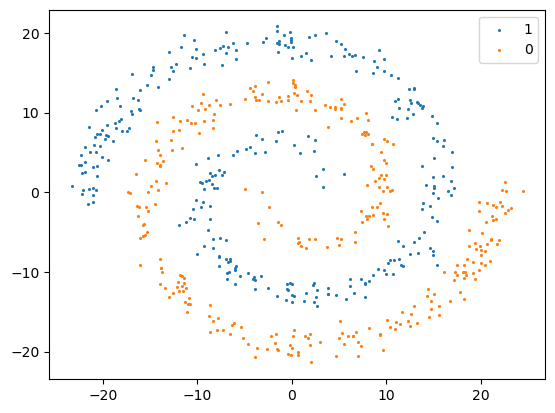

In [8]:
plt.scatter(label0[:, 0], label0[:, 1], s=1.5);
plt.scatter(label1[:, 0], label1[:, 1], s=1.5);
plt.legend([1, 0])

In [9]:
label1 = np.array([ data for data in testset if data[2] == 1])
label0 = np.array([ data for data in testset if data[2] == 0])

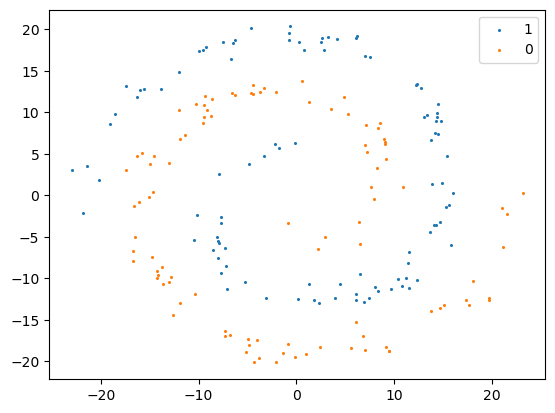

In [10]:
plt.scatter(label0[:, 0], label0[:, 1], s=1.5);
plt.scatter(label1[:, 0], label1[:, 1], s=1.5);
plt.legend([1, 0])

In [11]:
len(label0), len(label1)

(100, 100)

# Modeling

In [12]:
class Sequential:
    def __init__(self, layers):
        self.items = layers

    def derivative(self, error_d):
        return None
    
    def __call__(self, x):
        for obj in self.items :
            x = obj(x)
            
        return x 

In [13]:
class Sigmoid:
    def derivative(self):
        return self.sigmoid * (1 - self.sigmoid)

    def resetd(self):
        self.sigmoid = None
    
    def __call__(self, x):
        self.sigmoid = 1 / ( 1 + np.exp(-x) )
        return self.sigmoid

In [14]:
class LogSigmoid:
    def derivative(self):
        return 1 / (1 + np.exp(self.x))

    def resetd(self):
        self.x = None
    
    def __call__(self, x):
        self.x = x
        return np.log(1 / (1 + np.exp(-x)))

In [56]:
# dont use this, there's some miss calculation on derivative
class ReLU:
    def derivative(self):  
        return np.where(self.x > 0, 1.0, 0.0)

    def resetd(self):
        self.x = None
    
    def __call__(self, x):
        self.x = x
        # return (abs(x) + x ) / 2
        return np.maximum(0, self.x)

In [16]:
class Custom:
    def derivative(self):
        return (2 * self.x) / np.square(1 + np.square(self.x))

    def resetd(self):
        self.x = None

    def __call__(self, x):
        self.x = x 
        return 1 / (1 + np.square(x))

# Fungsi Hiperbolik 
https://id.wikipedia.org/wiki/Fungsi_hiperbolik

In [17]:
class Tanh:
    def derivative(self): 
        return 1 - (self.tanh * self.tanh)

    def resetd(self):
        self.tanh = None
        
    def __call__(self, x):
        self.tanh = ( np.exp(x) - np.exp(-x) ) / ( np.exp(x) + np.exp(-x) )
        return self.tanh

In [18]:
class Sech:
    def derivative(self):
        return ( self.ex * 2.0 * (1.0 - self.e2x) ) / (np.square(self.e2x + 1))

    def resetd(self):
        self.ex = None
        self.e2x = None

    def __call__(self, x):
        self.ex = np.exp(x)
        self.e2x = np.exp(2 * x)
        return (2.0 * self.ex) / ( self.e2x + 1.0 )

## Source : Derivative Cross Entropy
[Derivative of Binary Cross Entropy - why are my signs not right?](https://math.stackexchange.com/questions/2503428/derivative-of-binary-cross-entropy-why-are-my-signs-not-right)

In [19]:
class BinaryCrossEntropy:
    def derivative(self):
        return (self.y_pred - self.y_true) / (self.y_pred * (1 - self.y_pred))

    def resetd(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_pred, y_true):
        self.y_true = y_true
        self.y_pred = y_pred
        return - ((y_true * np.log(y_pred)) + ( (1 - y_true) * np.log(1 - y_pred) )) 

[The Log-sum-exp trick in Machine Learning](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/) <br>
[Numerical stability of binary cross entropy loss and the log-sum-exp trick](http://tagkopouloslab.ucdavis.edu/uncategorized/2018/09/numerical-stability-of-binary-cross-entropy-loss-and-log-sum-exp-trick/) <br>
[The log-sum-exp Trick](https://datumorphism.leima.is/cards/machine-learning/neural-networks/log-sum-exp-trick/)

In [20]:
class BinaryCrossEntropyWithLogits:
    # belum clear
    def derivative(self):         
        return -((2 * self.y_true) + 1)

    def resetd(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_pred, y_true):
        sigmoid = 1 / (1 + np.exp(-y_pred))
        
        self.y_true = y_true
        self.y_pred = sigmoid
        return - ((y_true * y_pred) + ( (1 - y_true) * (1 - y_pred) )) 

In [21]:
class SquareError:
    def derivative(self):
        return 2 * (self.y_pred - self.y_true)

    def resetd(self):
        self.y_true = None
        self.y_pred = None

    def __call__(self, y_pred, y_true):
        self.y_true = y_true 
        self.y_pred = y_pred 
        return np.square(y_true - y_pred)

In [22]:
class Linear:
    def __init__(self, input, output, bias=False):
        self.weight = np.random.randn(input, output)
        # self.weight = np.ones((input, output))
        
        if bias :
            # self.bias = np.ones((input, output))
            self.bias   = np.random.randn(1, output)

    def derivative_b(self, targetd=False):
        if targetd : 
            return 1
        return self.bias.T
    
    def derivative_w(self, targetd=False):
        if targetd: 
            return self.x   
        return self.weight.T

    def __call__(self, x):
        self.x = np.array([x]).repeat(self.weight.shape[1], axis=0)
        return np.matmul(x, self.weight) # + self.bias

In [23]:
class SGD:
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def __call__(self, weight, derivative, layer):
        self.call(weight, derivative)

    def call(self, weight, derivative, layer):
        derivative = derivative.T 
        return weight - (self.learning_rate * derivative)

In [24]:
class RMSprop:
    def __init__(self, learning_rate, alpha=0.99):
        self.learning_rate = learning_rate 
        self.alpha = alpha
        self.moving_avg = [1, 1, 1, 1, 1]

    def __call__(self, weight, derivative, layer):
        self.call(weight, derivative, layer)

    def call(self, weight, derivative, layer):
        moving_avg = self.alpha * self.moving_avg[layer] + (1 - self.alpha) * derivative ** 2
        self.moving_avg[layer] = moving_avg

        derivative = derivative.T
        moving_avg = moving_avg.T
        return weight - self.learning_rate * (derivative / moving_avg ** 0.5)

In [25]:
class Adam:
    def __init__(self, learning_rate, alpha=(0.999, 0.9), eps=1e-8):
        self.learning_rate = learning_rate
        self.alpha = alpha
        self.moving_avg = [0, 0, 0, 0, 0]
        self.momentum   = [0, 0, 0, 0, 0]
        self.eps = eps
        self.t = 0
        
    def __call__(self, weight, derivative, layer):
        self.call(weight, derivative, layer)

    def call(self, weight, derivative, layer):
        moving_avg = self.alpha[0] * self.moving_avg[layer] + (1 - self.alpha[0]) * derivative ** 2
        momentum = self.alpha[1] * self.momentum[layer] + (1 - self.alpha[1]) * derivative

        self.moving_avg[layer] = moving_avg
        self.momentum[layer] = momentum

        # bias correction
        if layer == 0:
            self.t += 1
        moving_avg = moving_avg / (1 - self.alpha[0] ** self.t)
        momentum   = momentum / (1 - self.alpha[1] ** self.t)

        derivative = derivative.T
        moving_avg = moving_avg.T
        momentum = momentum.T
        return weight - self.learning_rate * momentum / (moving_avg ** 0.5 + self.eps)
    

# Inisialisasi

In [81]:
model = Sequential([
    Linear(2, 32),
    Tanh(),
    Linear(32, 16),
    Tanh(),
    Linear(16, 8),
    Tanh(),
    Linear(8, 2),
    Tanh(),
    Linear(2, 1),
    Sigmoid()
])


In [82]:
error = BinaryCrossEntropy()
# error = SquareError()
optimizer = Adam(learning_rate=0.0001)

# Retrieve Data 

In [28]:
iterator = iter(trainset)

In [29]:
data = next(iterator)
source, target = data[:-1], data[-1] 
source, target, source.shape, target.shape

(array([16.95508615,  5.10735942]), np.float64(0.0), (2,), ())

# Feed Forward

In [30]:
output = model(source)
output.shape, output

((1,), array([0.37007732]))

In [31]:
loss = error(output, target)
loss.shape, loss

((1,), array([0.4621582]))

# Derivative
ID : mencari turunan parsial dari setiap layer neural network. Semua ini didapat dari mencari manual secara tulis tangan. :( <br>
EN : calculate partial derivatives of each layer of the neural network. All of this was obtained by manually searching by hand.  :(

In [32]:
def derv1(error, model):
    return error.derivative() * model.items[-1].derivative() * model.items[-2].derivative_w(True)
derv1(error, model).shape

(1, 2)

In [33]:
def derv2(error, model):
    d2 = error.derivative() * model.items[-1].derivative() * model.items[-2].derivative_w(False) * model.items[-3].derivative()
    d2 = d2.T * model.items[-4].derivative_w(True)
    return d2 
derv2(error, model).shape

(2, 16)

In [34]:
def derv3(error, model):
    d3_1 = error.derivative() * model.items[-1].derivative() * model.items[-2].derivative_w(False) * model.items[-3].derivative()
    d3_2 = model.items[-4].derivative_w(False) * model.items[-5].derivative()
    d3_3 = model.items[-6].derivative_w(True)
    
    d3 = d3_1.T * d3_2
    input = np.array([d3_3[0]]).repeat(d3.shape[0], axis=0)
    d3 = np.dot(d3.T, input)
    return d3
derv3(error, model).shape

(16, 8)

In [35]:
def derv4(error, model):
    d4_1 = error.derivative() * model.items[-1].derivative() * model.items[-2].derivative_w(False) * model.items[-3].derivative()
    d4_2 = model.items[-4].derivative_w(False) * model.items[-5].derivative()
    d4_3 = model.items[-6].derivative_w(False) * model.items[-7].derivative()
    d4_4 = model.items[-8].derivative_w(True)
    
    first = d4_1.T * d4_2
    second = np.dot(first, d4_3)
    second = np.dot(second.T, np.ones((second.shape[0], 1)))
    third = ( second * d4_4 )
    
    return third 
derv4(error, model).shape

(8, 8)

In [36]:
def derv5(error, model):
    d5_1 = error.derivative() * model.items[-1].derivative() * model.items[-2].derivative_w(False) * model.items[-3].derivative()
    d5_2 = model.items[-4].derivative_w(False) * model.items[-5].derivative()
    d5_3 = model.items[-6].derivative_w(False) * model.items[-7].derivative()
    d5_4 = model.items[-8].derivative_w(False) * model.items[-9].derivative()
    d5_5 = model.items[-10].derivative_w(True)
    
    first = d5_1.T * d5_2
    second = np.dot(first, d5_3)
    second = np.dot(second.T, np.ones((second.shape[0], 1)))
    third = d5_4 * second
    third = np.dot(third.T, np.ones((third.shape[0], 1)))
    four = third * d5_5
    
    return four
derv5(error, model).shape

(8, 2)

# Update Weight

In [37]:
model.items

In [38]:
# model.items[-1].weight.shape, model.items[-3].weight.shape, model.items[-5].weight.shape, 

In [39]:
def update_weight(d1, d2, d3, d4, d5, model, optimizer):
    model.items[-2].weight = optimizer.call(model.items[-2].weight, d1, 0)
    model.items[-4].weight = optimizer.call(model.items[-4].weight, d2, 1)
    model.items[-6].weight = optimizer.call(model.items[-6].weight, d3, 2)
    model.items[-8].weight = optimizer.call(model.items[-8].weight, d4, 3)
    model.items[-10].weight = optimizer.call(model.items[-10].weight, d5, 4)

d1 = derv1(error, model)
d2 = derv2(error, model)
d3 = derv3(error, model)
d4 = derv4(error, model)
d5 = derv5(error, model)
update_weight(d1, d2, d3, d4, d5, model, optimizer)

In [40]:
# model.items[-1].weight.shape, model.items[-3].weight.shape, model.items[-5].weight.shape, 

# Loop Train

In [41]:
def loop_fn(model, error, optimizer, dataset, total_loss, training=True):
    cost = 0
    for data in ((dataset)) :
        source, target = data[:-1], data[-1]
    
        # forward 
        output = model(source)
        loss = error(output, target)
    
        # hitung turunan / derivative
        if training : 
            d1 = derv1(error, model)
            d2 = derv2(error, model)
            d3 = derv3(error, model)
            d4 = derv4(error, model)
            d5 = derv5(error, model)
            # d4 = None
            
            # update weight 
            update_weight(d1, d2, d3, d4, d5, model, optimizer)

        cost += loss[0]
        total_loss.append(loss[0])
        
        # pbar.set_postfix({
        #     'loss' : loss[0, 0]
        # })
        # time.sleep(0.1)

    cost = cost / len(dataset)
    # print(f"Total Cost: {cost}")
    return cost

In [83]:
train_cost = []
train_loss = []

test_cost = []
test_loss = []

  0%|                                                      | 0/1000 [00:00<?, ?it/s, train_cost=0.779, test_cost=0.978]

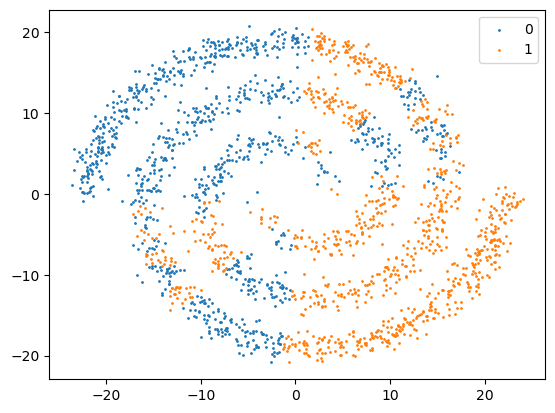

  2%|▉                                            | 20/1000 [00:11<08:38,  1.89it/s, train_cost=0.587, test_cost=0.739]

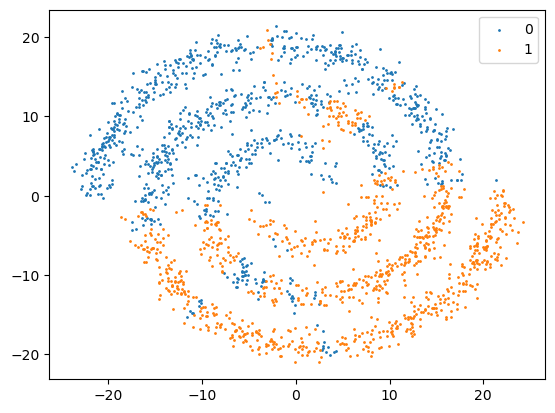

  4%|█▊                                           | 40/1000 [00:22<08:15,  1.94it/s, train_cost=0.545, test_cost=0.708]

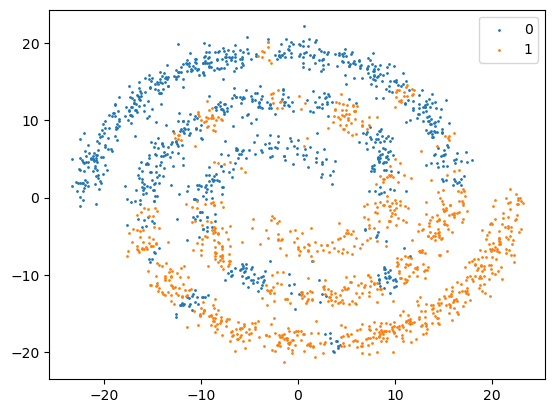

  6%|██▋                                          | 60/1000 [00:32<08:01,  1.95it/s, train_cost=0.517, test_cost=0.676]

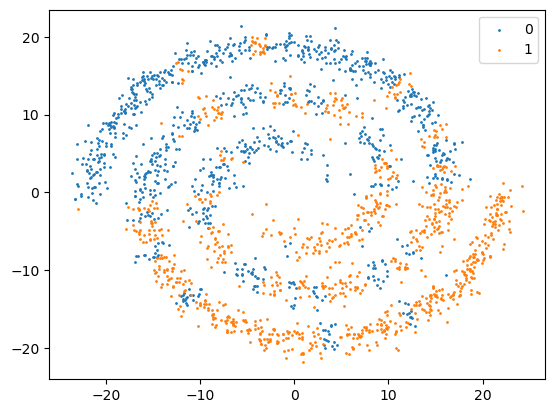

  8%|███▌                                         | 80/1000 [00:43<07:47,  1.97it/s, train_cost=0.491, test_cost=0.652]

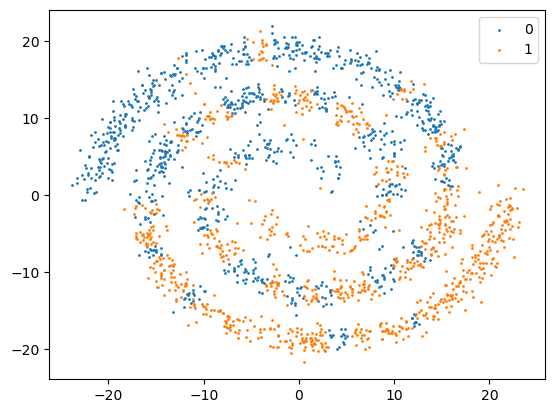

 10%|████▌                                        | 100/1000 [00:53<07:39,  1.96it/s, train_cost=0.46, test_cost=0.619]

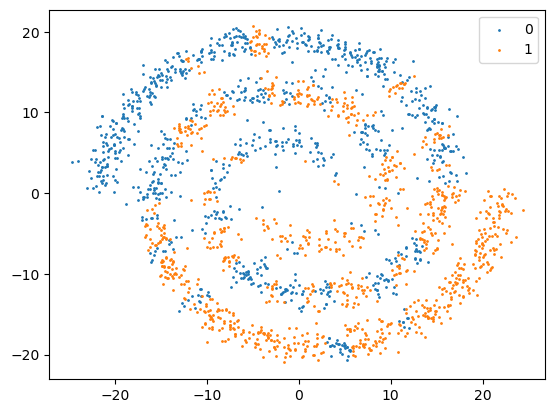

 12%|█████▎                                      | 120/1000 [01:04<07:26,  1.97it/s, train_cost=0.417, test_cost=0.573]

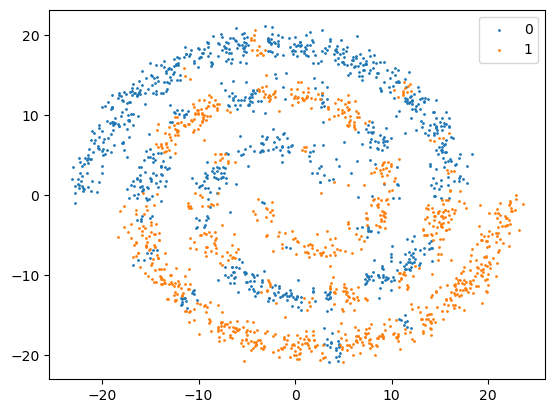

 14%|██████▏                                     | 140/1000 [01:15<07:17,  1.97it/s, train_cost=0.355, test_cost=0.498]

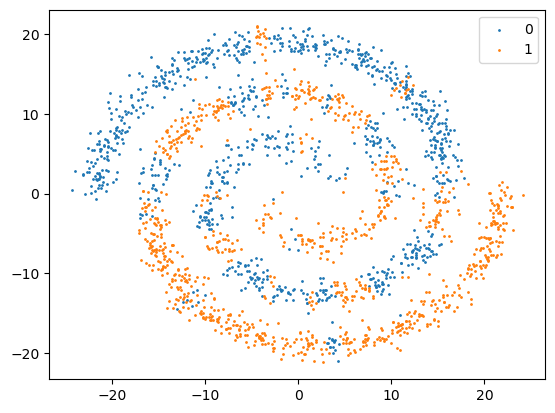

 16%|███████                                     | 160/1000 [01:25<07:11,  1.95it/s, train_cost=0.306, test_cost=0.439]

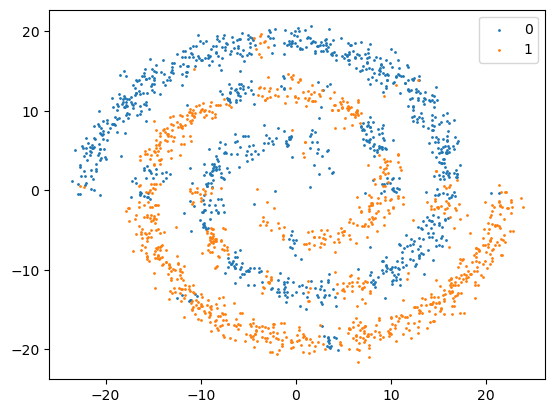

 18%|███████▉                                    | 180/1000 [01:36<07:00,  1.95it/s, train_cost=0.268, test_cost=0.391]

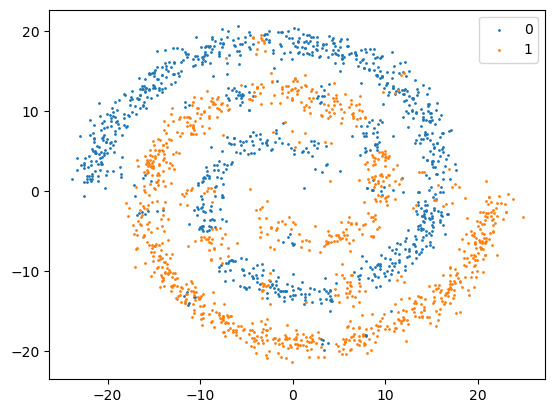

 20%|████████▊                                   | 200/1000 [01:47<06:56,  1.92it/s, train_cost=0.238, test_cost=0.359]

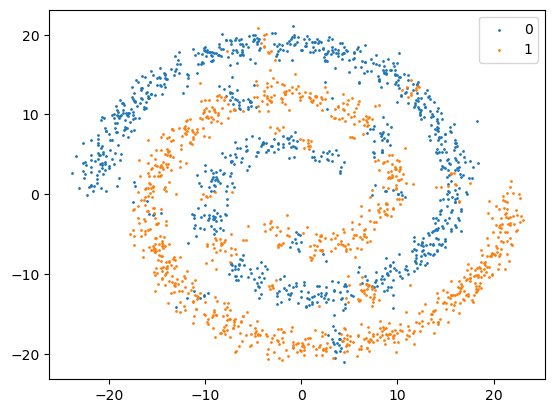

 22%|█████████▋                                  | 220/1000 [01:57<06:39,  1.95it/s, train_cost=0.214, test_cost=0.332]

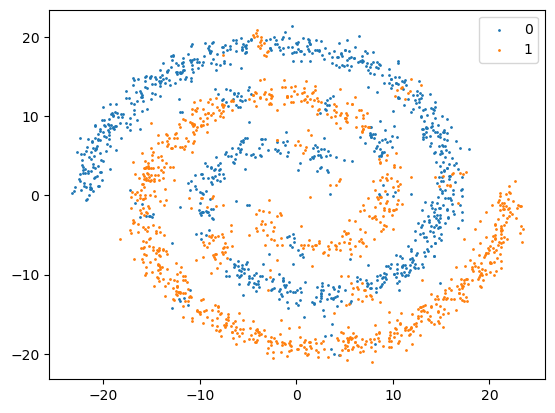

 24%|██████████▌                                 | 240/1000 [02:08<06:27,  1.96it/s, train_cost=0.192, test_cost=0.318]

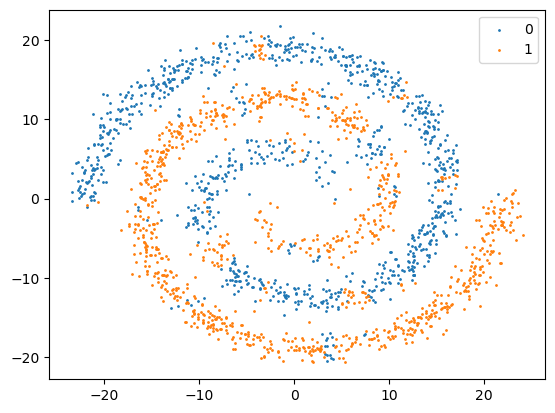

 26%|███████████▍                                | 260/1000 [02:19<06:22,  1.94it/s, train_cost=0.172, test_cost=0.303]

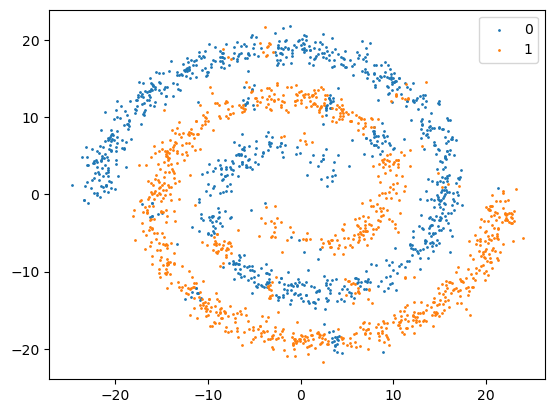

 28%|████████████▎                               | 280/1000 [02:29<05:55,  2.02it/s, train_cost=0.155, test_cost=0.288]

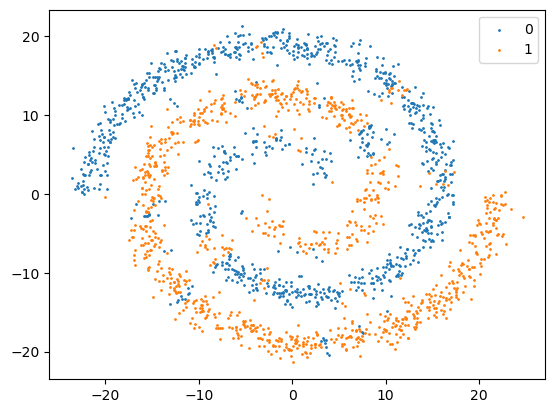

 30%|█████████████▏                              | 300/1000 [02:39<05:42,  2.05it/s, train_cost=0.142, test_cost=0.274]

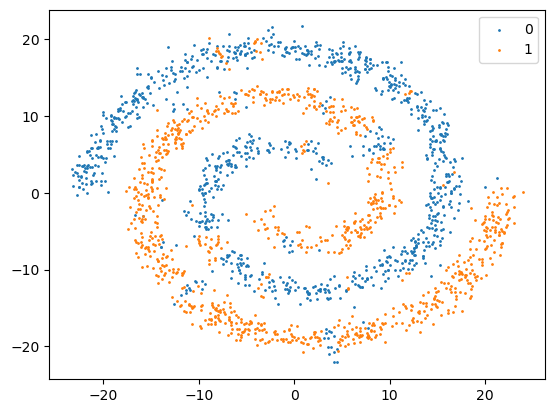

 32%|██████████████▋                               | 320/1000 [02:50<05:36,  2.02it/s, train_cost=0.13, test_cost=0.26]

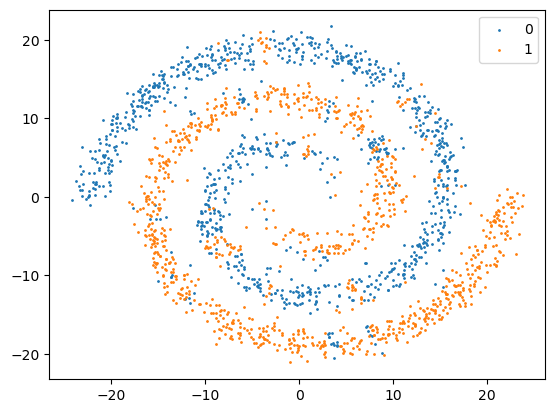

 34%|██████████████▉                             | 340/1000 [03:00<05:31,  1.99it/s, train_cost=0.121, test_cost=0.248]

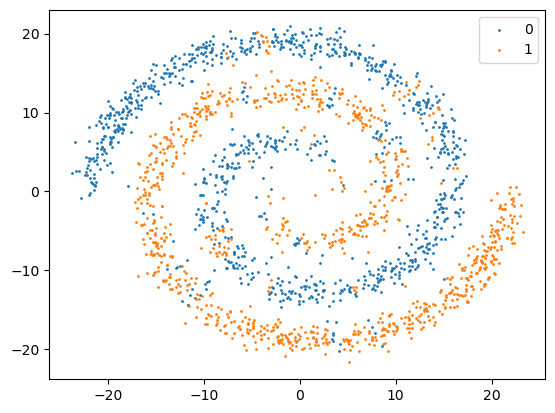

 36%|███████████████▊                            | 360/1000 [03:11<05:40,  1.88it/s, train_cost=0.112, test_cost=0.238]

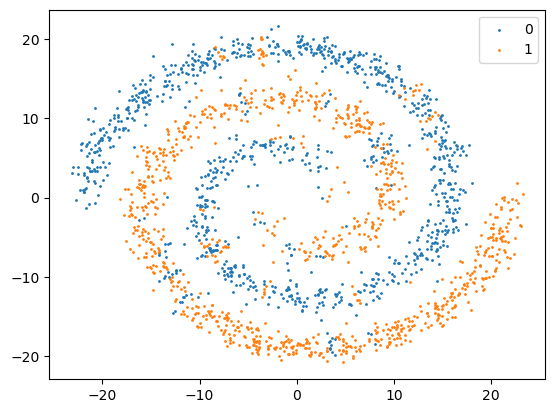

 38%|████████████████▋                           | 380/1000 [03:21<05:19,  1.94it/s, train_cost=0.104, test_cost=0.228]

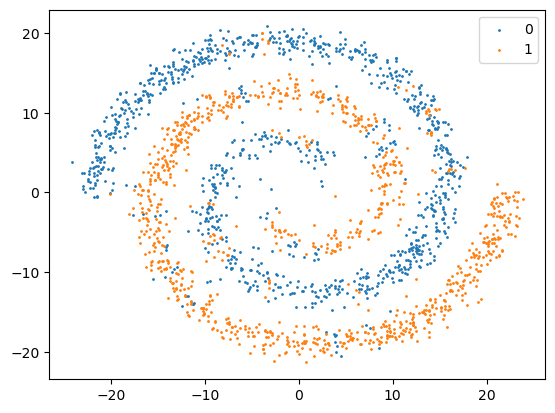

 40%|█████████████████▏                         | 400/1000 [03:32<05:15,  1.90it/s, train_cost=0.0974, test_cost=0.219]

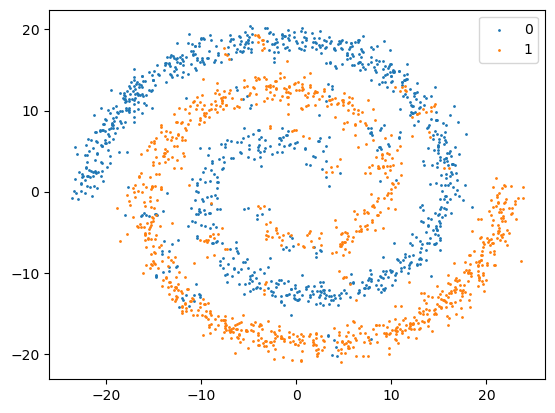

 42%|██████████████████                         | 420/1000 [03:44<05:34,  1.73it/s, train_cost=0.0917, test_cost=0.212]

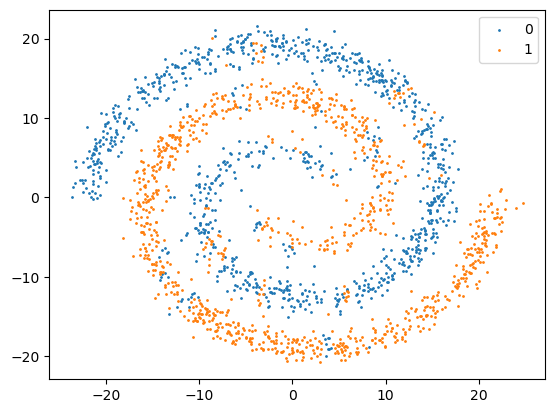

 44%|██████████████████▉                        | 440/1000 [03:56<05:58,  1.56it/s, train_cost=0.0865, test_cost=0.207]

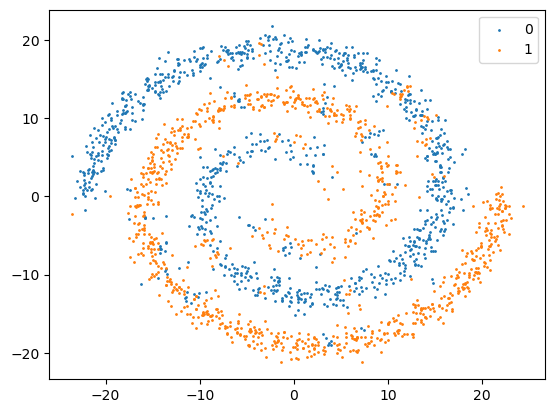

 46%|███████████████████▊                       | 460/1000 [04:06<04:36,  1.95it/s, train_cost=0.0809, test_cost=0.203]

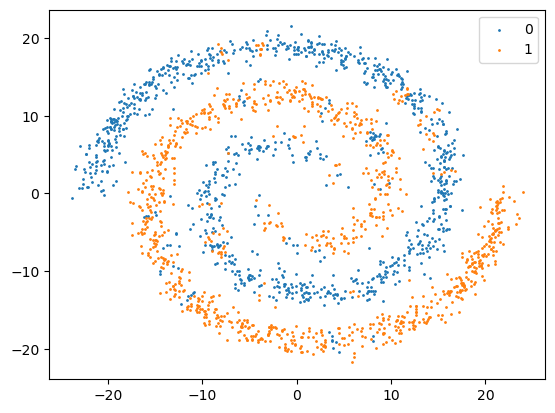

 48%|████████████████████▋                      | 480/1000 [04:17<04:29,  1.93it/s, train_cost=0.0742, test_cost=0.199]

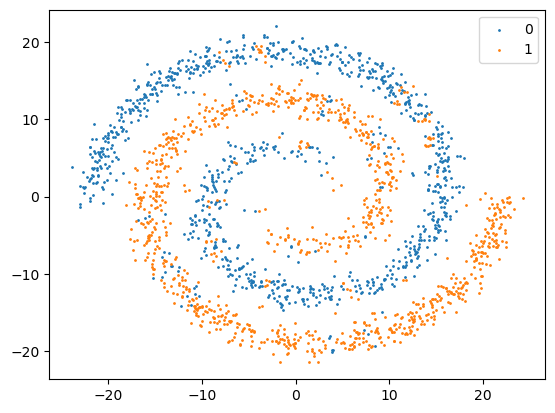

 50%|█████████████████████▌                     | 500/1000 [04:27<04:19,  1.92it/s, train_cost=0.0681, test_cost=0.193]

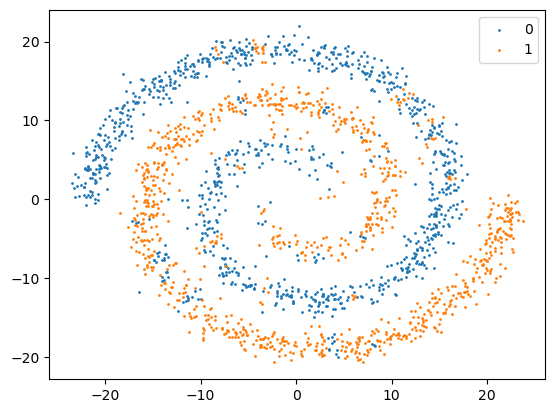

 52%|██████████████████████▎                    | 520/1000 [04:38<04:06,  1.94it/s, train_cost=0.0621, test_cost=0.183]

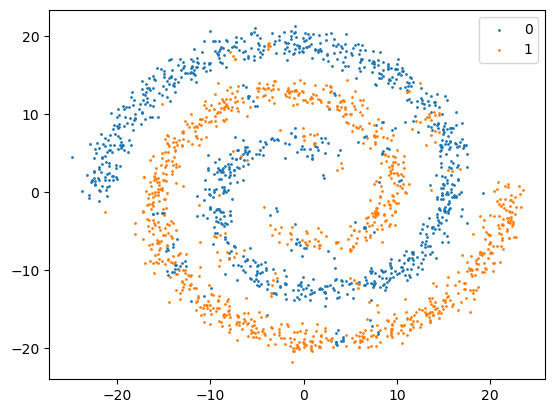

 54%|███████████████████████▏                   | 540/1000 [04:49<03:57,  1.93it/s, train_cost=0.0556, test_cost=0.169]

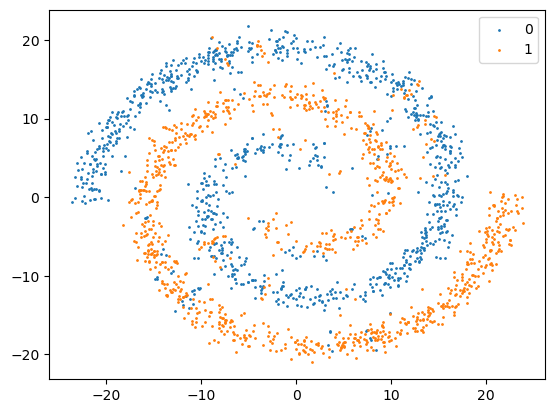

 56%|████████████████████████                   | 560/1000 [04:59<03:52,  1.90it/s, train_cost=0.0486, test_cost=0.159]

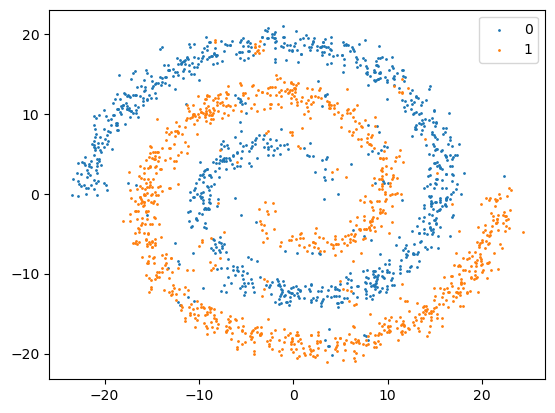

 58%|████████████████████████▉                  | 580/1000 [05:10<03:24,  2.05it/s, train_cost=0.0422, test_cost=0.156]

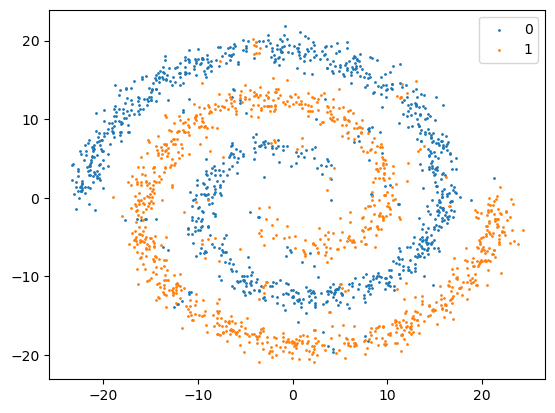

 60%|█████████████████████████▊                 | 600/1000 [05:20<03:15,  2.05it/s, train_cost=0.0363, test_cost=0.154]

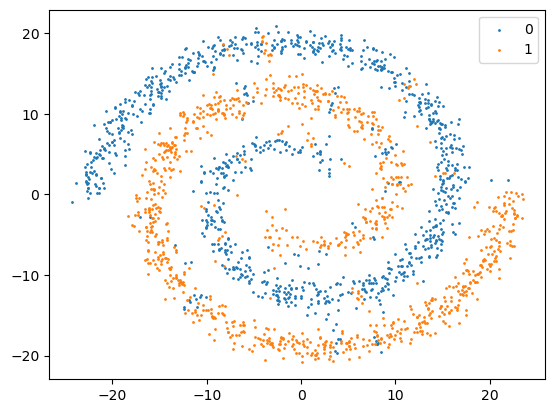

 62%|██████████████████████████▋                | 620/1000 [05:30<03:04,  2.06it/s, train_cost=0.0298, test_cost=0.152]

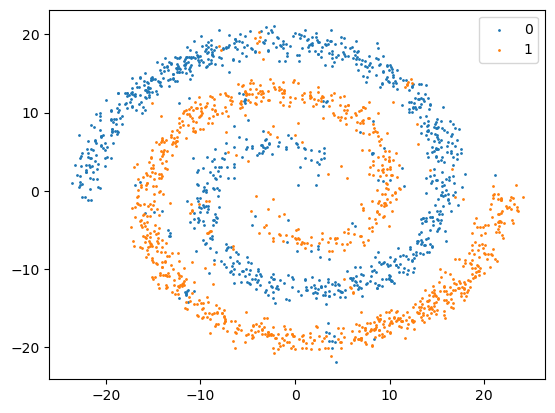

 64%|████████████████████████████▏               | 640/1000 [05:40<02:55,  2.05it/s, train_cost=0.0243, test_cost=0.15]

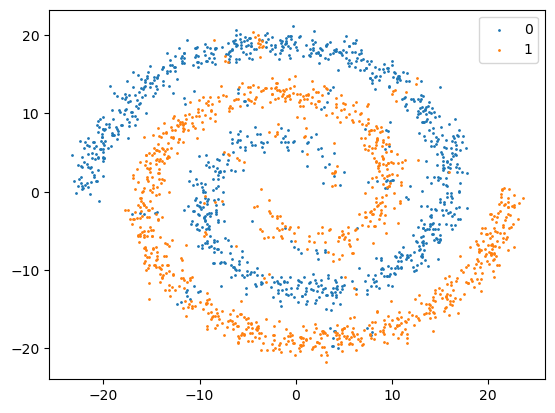

 66%|████████████████████████████▍              | 660/1000 [05:50<02:46,  2.04it/s, train_cost=0.0199, test_cost=0.147]

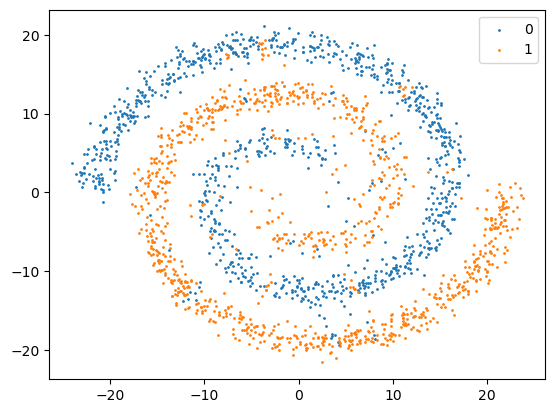

 68%|█████████████████████████████▏             | 680/1000 [06:00<02:35,  2.05it/s, train_cost=0.0186, test_cost=0.149]

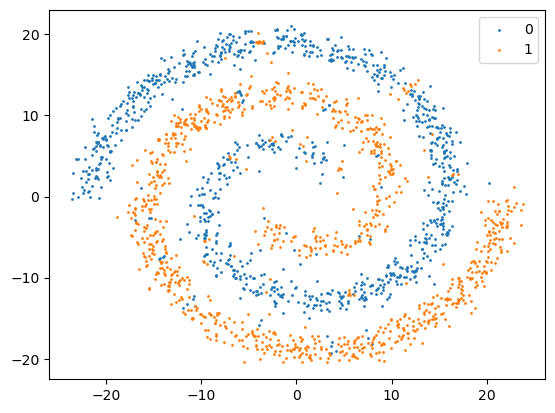

 70%|██████████████████████████████             | 700/1000 [06:10<02:36,  1.91it/s, train_cost=0.0157, test_cost=0.139]

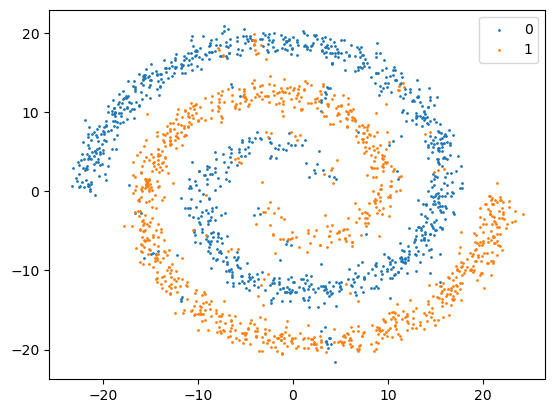

 72%|██████████████████████████████▉            | 720/1000 [06:21<02:23,  1.96it/s, train_cost=0.0123, test_cost=0.144]

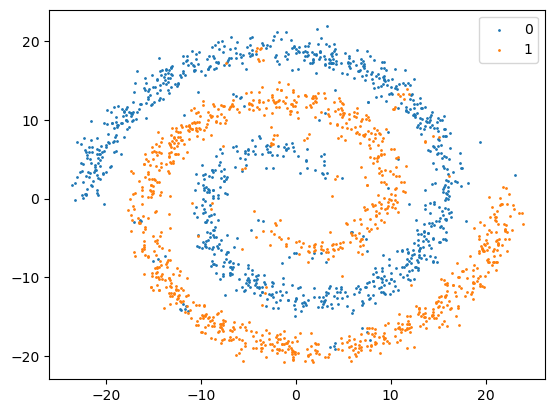

 74%|███████████████████████████████           | 740/1000 [06:32<02:14,  1.93it/s, train_cost=0.00865, test_cost=0.138]

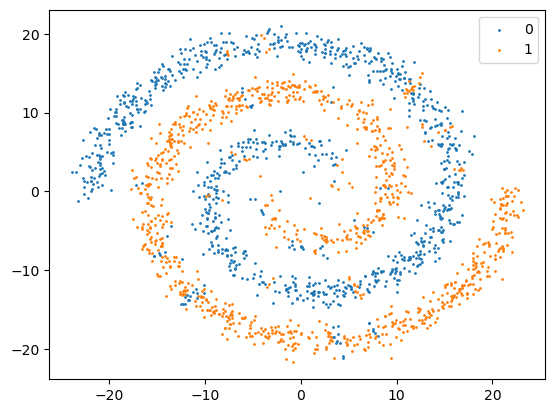

 76%|███████████████████████████████▉          | 760/1000 [06:43<02:06,  1.90it/s, train_cost=0.00825, test_cost=0.141]

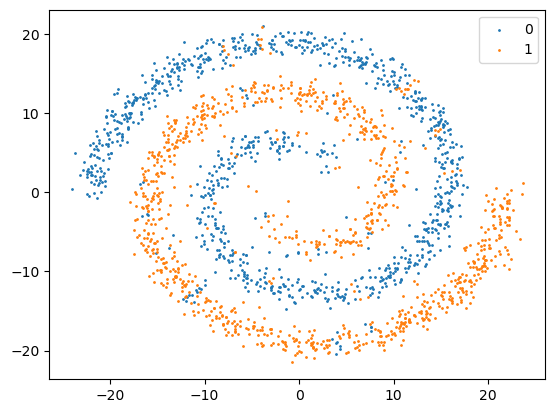

 78%|█████████████████████████████████▌         | 780/1000 [06:54<01:56,  1.89it/s, train_cost=0.0179, test_cost=0.137]

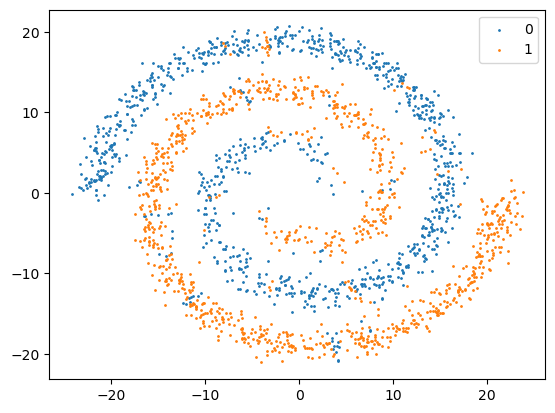

 80%|██████████████████████████████████▍        | 800/1000 [07:05<01:42,  1.95it/s, train_cost=0.0112, test_cost=0.137]

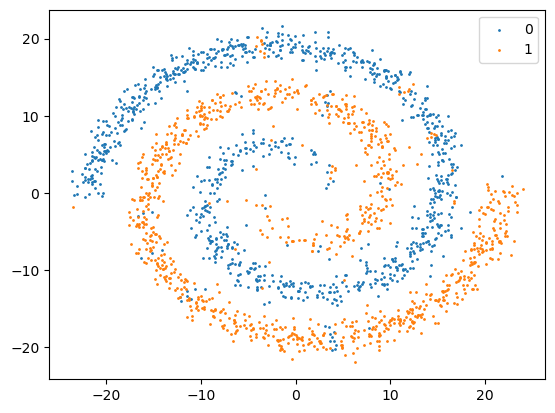

 82%|██████████████████████████████████▍       | 820/1000 [07:16<01:33,  1.92it/s, train_cost=0.00994, test_cost=0.137]

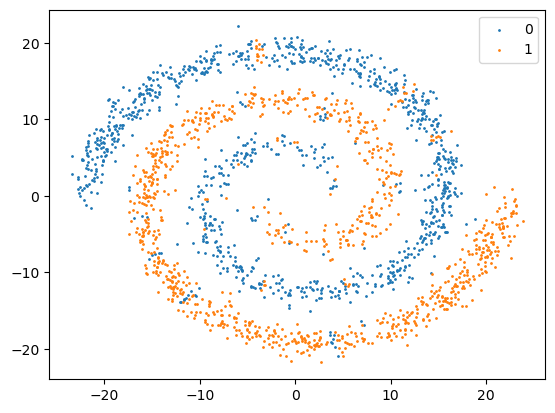

 84%|████████████████████████████████████       | 840/1000 [07:26<01:22,  1.94it/s, train_cost=0.00743, test_cost=0.14]

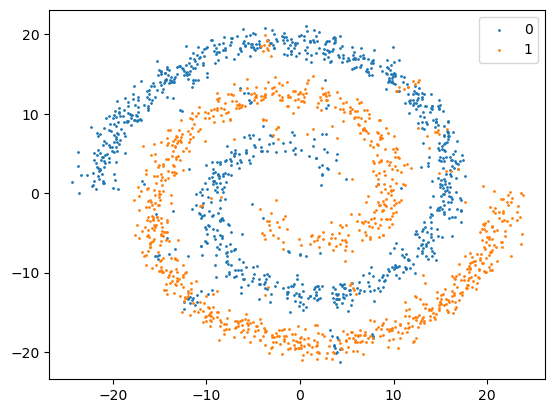

 86%|████████████████████████████████████      | 860/1000 [07:37<01:15,  1.85it/s, train_cost=0.00378, test_cost=0.148]

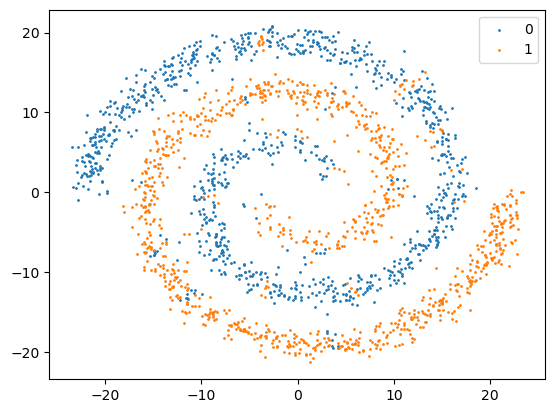

 88%|████████████████████████████████████▉     | 880/1000 [07:48<01:05,  1.84it/s, train_cost=0.00312, test_cost=0.153]

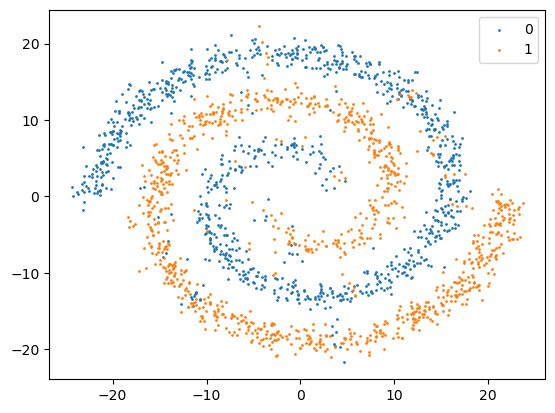

 90%|███████████████████████████████████████▌    | 900/1000 [07:59<00:52,  1.91it/s, train_cost=0.0101, test_cost=0.15]

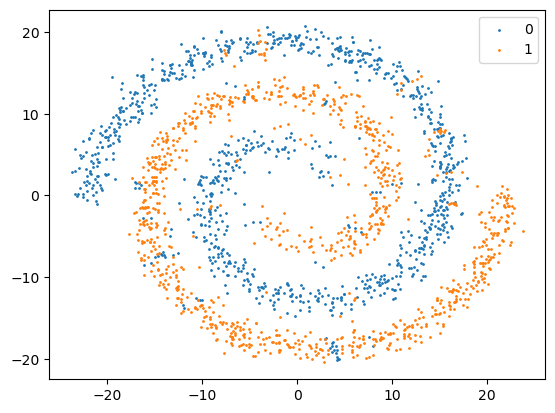

 92%|███████████████████████████████████████▌   | 920/1000 [08:10<00:42,  1.87it/s, train_cost=0.0103, test_cost=0.156]

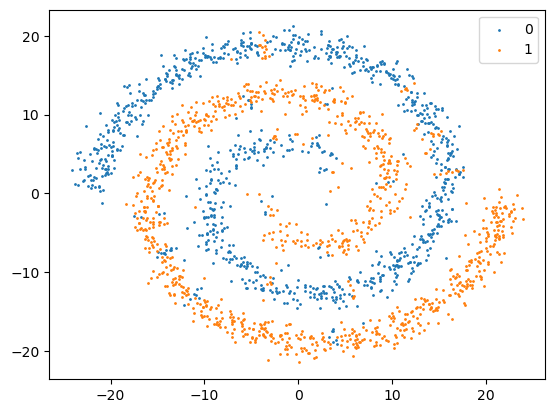

 94%|███████████████████████████████████████▍  | 940/1000 [08:21<00:30,  1.99it/s, train_cost=0.00216, test_cost=0.166]

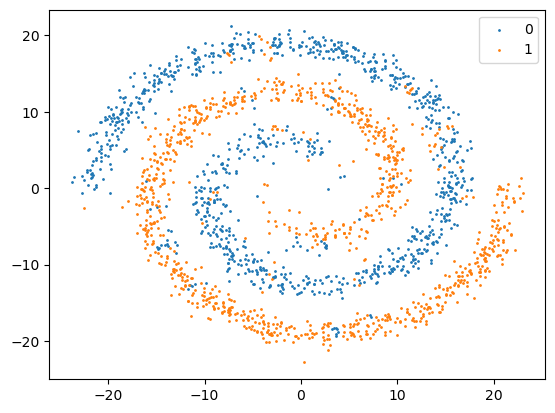

 96%|████████████████████████████████████████▎ | 960/1000 [08:32<00:20,  1.96it/s, train_cost=0.00196, test_cost=0.171]

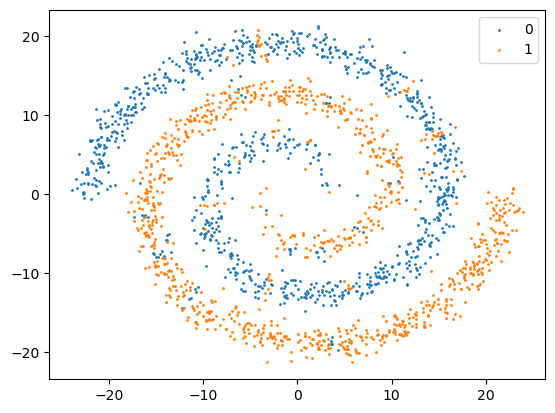

 98%|█████████████████████████████████████████▏| 980/1000 [08:43<00:10,  1.92it/s, train_cost=0.00166, test_cost=0.163]

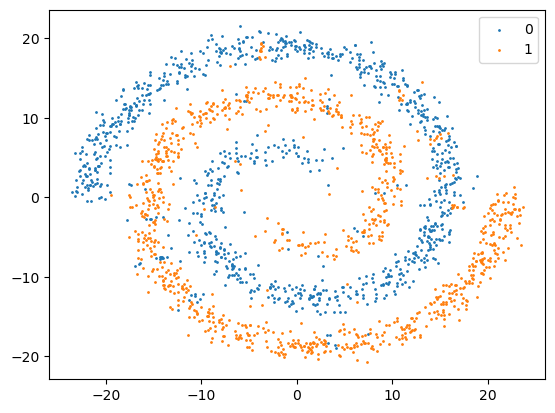

100%|█████████████████████████████████████████| 1000/1000 [08:53<00:00,  1.87it/s, train_cost=0.00868, test_cost=0.162]


In [84]:
for epoch, _ in enumerate(pbar := tqdm(range(1000))):
    cost = loop_fn(model, error, optimizer, trainset, train_loss)
    train_cost.append(cost)

    cost = loop_fn(model, error, optimizer, testset, test_loss, False)
    test_cost.append(cost)
    pbar.set_postfix({
        'train_cost' : train_cost[-1],
        'test_cost' : cost
    })

    if epoch % 20 == 0: 
        plot_data_with_model(model, spiral(1000, 3, 2)[:, :2])
    # time.sleep(0.1)
    # if cost < 0.01:
        # break
    

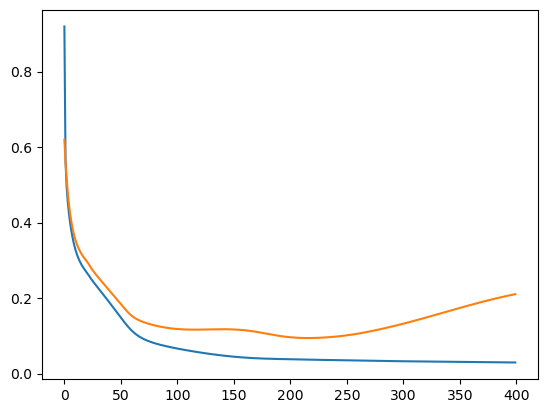

In [77]:
plt.plot(train_cost);
plt.plot(test_cost);

In [78]:
# plt.plot(train_loss);
# plt.plot(test_loss);

# Apa yang disimpulkan model

In [47]:
def plot_data_with_model(model, data):
    label = (model(data) > 0.5) * 1.0
    model = Sequential(model.items[:-2])
    data = (model(data))

    data = np.stack((data[:, 1], data[:, 0], label[:, 0])).T
    label0 = np.array([x for x in data if x[2] == 0])
    label1 = np.array([x for x in data if x[2] == 1])

    if len(label0) > 0 :
        plt.scatter(label0[:, 0], label0[:, 1], s=1)
    if len(label1) > 0 :
        plt.scatter(label1[:, 0], label1[:, 1], s=1)
    plt.legend([0, 1])
    plt.show()

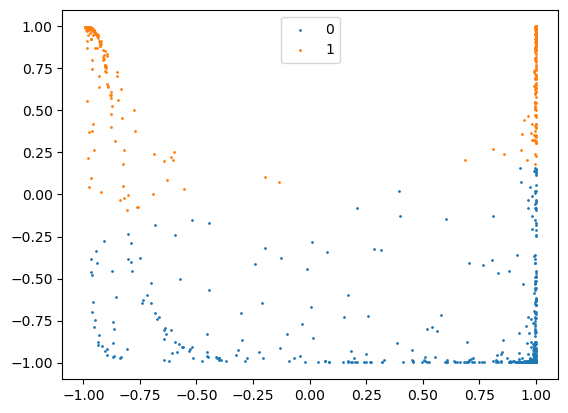

In [48]:
plot_data_with_model(model, kotak_kotak(1000)[:, :2])

In [44]:
def plot_data_with_model(model, data):
    label = (model(data) > 0.5) * 1.0

    data = np.stack((data[:, 0], data[:, 1], label[:, 0])).T
    label0 = np.array([x for x in data if x[2] == 0])
    label1 = np.array([x for x in data if x[2] == 1])

    if len(label0) > 0 :
        plt.scatter(label0[:, 0], label0[:, 1], s=1)
    if len(label1) > 0 :
        plt.scatter(label1[:, 0], label1[:, 1], s=1)
    plt.legend([0, 1])
    plt.show()

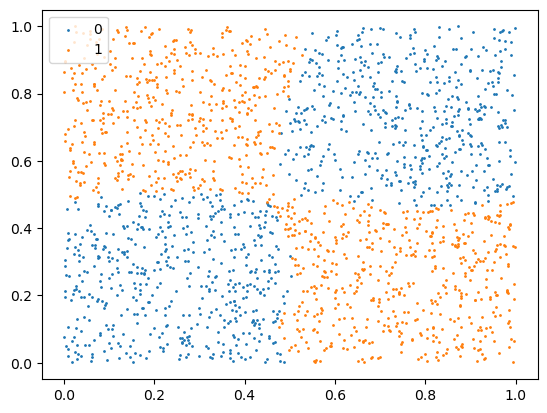

In [50]:
plot_data_with_model(model, kotak_kotak(2000)[:, :2])

In [49]:
x = (np.random.rand(10000) * 60) - 30
y = (np.random.rand(10000) * 40) - 20

# Create a grid of points
xy = np.array([x, y]).T
xy.shape

(10000, 2)

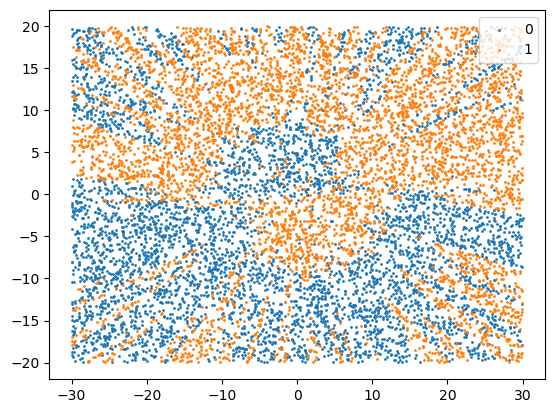

In [65]:
plot_data_with_model(model, xy)

In [130]:
np.sqrt(-1)

C:\Users\JejakSiGundul\AppData\Local\Temp\ipykernel_8540\3438155168.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(-1)


nan

In [47]:
np.maximum(data, 0)

array([0.        , 1.02778139, 0.63173797, 0.96562583, 0.        ,
       0.        , 1.3678197 , 1.34386794, 0.77841722, 0.        ])

In [ ]:
np.log1p()

In [79]:
data = np.random.randn(10)

log_data = np.log1p(np.maximum(data, 0))

In [85]:
np.log(-1)

C:\Users\JejakSiGundul\AppData\Local\Temp\ipykernel_7020\153577755.py:1: RuntimeWarning: invalid value encountered in log
  np.log(-1)


nan

In [46]:
log_data

array([0.        , 0.70694228, 0.48964569, 0.67581069, 0.        ,
       0.        , 0.86196957, 0.85180253, 0.57572376, 0.        ])